In [1]:
! pip uninstall transformers -y -q
! pip install transformers[torch] -q
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
df= pd.read_csv("/content/drive/MyDrive/Restaurant reviews.csv")

In [4]:
df = df[["Review" , "Rating"]]

In [5]:
df = df.dropna()

In [6]:
df.head()

,Review,Rating
0,"The ambience was good, food was quite good . h...",5
1,Ambience is too good for a pleasant evening. S...,5
2,A must try.. great food great ambience. Thnx f...,5
3,Soumen das and Arun was a great guy. Only beca...,5
4,Food is good.we ordered Kodi drumsticks and ba...,5


In [7]:
df.describe()

,Review,Rating
count,9955,9955
unique,9364,10
top,good,5
freq,237,3826


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9955 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  9955 non-null   object
 1   Rating  9955 non-null   object
dtypes: object(2)
memory usage: 233.3+ KB
None


<Axes: xlabel='Rating', ylabel='count'>

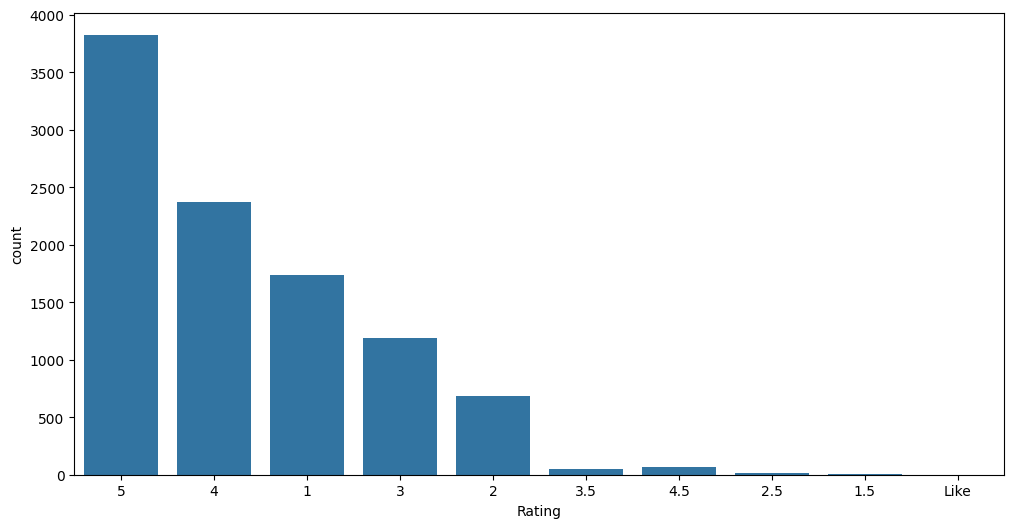

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='Rating',data=df)

In [10]:
df = df[df['Rating'].isin(['1', '5'])]

In [11]:
df['Rating'].value_counts()

Rating
5    3826
1    1735
Name: count, dtype: int64

In [12]:
def sample_by_senimwnt(df, sample_size=1200):
  sampled_df = pd.DataFrame()
  for value in df['Rating'].unique():
    subset = df[df['Rating'] == value]
    if len(subset) >= sample_size:
      sampled_df = pd.concat([sampled_df, subset.sample(sample_size)], ignore_index=True)
    else:
      sampled_df = pd.concat([sampled_df, subset], ignore_index=True)  # Include all rows if less than sample size

  return sampled_df


In [13]:
df = sample_by_senimwnt(df)

In [14]:
df.shape

(2400, 2)

In [15]:
df['Review'][0], df['Rating'][0]

('Enjoyed the atmosphere and ambience. Especially I visited this place on a rainy day. They have small lobby with upto 20 seating.\nI enjoyed that moment with drizzle and my drink.\nI tried some fish item, I forget the name of the dish ..its finger licking dish. And tangidi biryani was taste less, no salt, no masala, may cheif might forgotten to add all these.\nIPL or PL or UEFA in Arena...you love it with crowd',
 '5')

In [16]:
df['sentiment'] = df['Rating'].replace({'5': 1, '1': 0})
df = df.drop('Rating',axis=1)
df.head()

,Review,sentiment
0,Enjoyed the atmosphere and ambience. Especiall...,1
1,Excellent service and ambience and very friend...,1
2,This place always exceeds expectations!!! Frie...,1
3,It was awesome having fun @prism great environ...,1
4,thanks,1


In [17]:
df.head()

,Review,sentiment
0,Enjoyed the atmosphere and ambience. Especiall...,1
1,Excellent service and ambience and very friend...,1
2,This place always exceeds expectations!!! Frie...,1
3,It was awesome having fun @prism great environ...,1
4,thanks,1


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Review'],df['sentiment'],test_size=0.2)

len(X_train), len(X_test)

(1920, 480)

In [19]:
X_train, X_test, y_train, y_test = list(X_train), list(X_test), list(y_train), list(y_test)
X_train[:2], y_train[:2]

(['full money taken but incomplete order...folld is stale cold and half is missing...not acceptable...this is for 2nd time similar experience with zomato',
  'chicken bad smell and seems it got spoiled.'],
 [0, 0])

In [20]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [21]:
# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [22]:
class data(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, index):
    item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[index])
    return item

  def __len__(self):
    return len(self.labels)

In [23]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name,model_max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [24]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

train_dataset = data(train_encoding, y_train)
test_dataset = data(test_encoding, y_test)

In [25]:
training_args = TrainingArguments(
  output_dir='./results',            # Directory where model checkpoints & results will be saved
  num_train_epochs=2,                # No of training epochs
  per_device_train_batch_size=32,    # Batch size for training per device
  per_device_eval_batch_size=32,     # Batch size for evaluation per device
  learning_rate=2e-05,               # Learning rate for optimizer
  warmup_steps=500,                  # No of warmup steps for the learning rate scheduler
  weight_decay=0.01,                 # Weight decay coefficient for regularization
  logging_dir='./logs',              # Directory for logging training information
  load_best_model_at_end=True,       # Whether to load the best model from checkpoints at the end of training
  logging_steps=200,                 # Log training metrics every `logging_steps` steps
  save_steps=400,                    # Save model checkpoints every `save_steps` steps
  evaluation_strategy="steps",       # Evaluate on the evaluation dataset every `logging_steps` steps
)

In [26]:
model = DistilBertForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
from accelerate import Accelerator

# Initialize Accelerator and Trainer
Accelerator()
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=120, training_loss=0.273173459370931, metrics={'train_runtime': 178.2127, 'train_samples_per_second': 21.547, 'train_steps_per_second': 0.673, 'total_flos': 508674810839040.0, 'train_loss': 0.273173459370931, 'epoch': 2.0})

In [31]:
def predict_sentiment(model, tokenizer, text, device):
    if torch.cuda.is_available() and device == 'cuda':
        model.to('cuda')
    tokenized = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    outputs = model(**tokenized)
    probs = F.softmax(outputs.logits, dim=-1)
    preds = torch.argmax(outputs.logits, dim=-1).item()
    probs_max = probs.max().detach().cpu().numpy()
    prediction = "Positive" if preds == 1 else "Negative"
    print(f'{text}\nSentiment: {prediction}\tProbability: {probs_max*100:.2f}%\n', end="-"*50 + "\n")

In [32]:
text = 'Impeccable service, luxurious amenities, and breathtaking views. The epitome of comfort and relaxation. A truly unforgettable stay'
predict_sentiment(model, tokenizer, text, device)

Impeccable service, luxurious amenities, and breathtaking views. The epitome of comfort and relaxation. A truly unforgettable stay
Sentiment: Positive	Probability: 95.13%
--------------------------------------------------


In [33]:
text = 'Disappointed by cleanliness standards, noisy surroundings, and subpar amenities. Not worth the price for the experience provided.'
predict_sentiment(model, tokenizer, text, device)

Disappointed by cleanliness standards, noisy surroundings, and subpar amenities. Not worth the price for the experience provided.
Sentiment: Negative	Probability: 90.97%
--------------------------------------------------


In [34]:
bert_model_dir = "bert_finetuned"

In [35]:
trainer.save_model("bert_model_dir")
tokenizer.save_pretrained("bert_model_dir")

('bert_model_dir/tokenizer_config.json',
 'bert_model_dir/special_tokens_map.json',
 'bert_model_dir/vocab.txt',
 'bert_model_dir/added_tokens.json',
 'bert_model_dir/tokenizer.json')

In [39]:
tokenizer2 = DistilBertTokenizerFast.from_pretrained("bert_model_dir",model_max_length=512)
model2 = DistilBertForSequenceClassification.from_pretrained("bert_model_dir")

In [40]:
text = 'Impeccable service, luxurious amenities, and breathtaking views. The epitome of comfort and relaxation. A truly unforgettable stay'
predict_sentiment(model2, tokenizer2, text, device)

Impeccable service, luxurious amenities, and breathtaking views. The epitome of comfort and relaxation. A truly unforgettable stay
Sentiment: Positive	Probability: 93.65%
--------------------------------------------------


In [42]:
! zip -r bert_model_dir.zip bert_model_dir

  adding: bert_model_dir/ (stored 0%)
  adding: bert_model_dir/tokenizer_config.json (deflated 76%)
  adding: bert_model_dir/special_tokens_map.json (deflated 42%)
  adding: bert_model_dir/config.json (deflated 46%)
  adding: bert_model_dir/model.safetensors (deflated 8%)
  adding: bert_model_dir/tokenizer.json (deflated 71%)
  adding: bert_model_dir/training_args.bin (deflated 51%)
  adding: bert_model_dir/vocab.txt (deflated 53%)
